In [1]:
import matplotlib.pyplot as plt
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
import pandas as pd

## Visualizing Training Data

In [3]:
train = pd.read_csv('train.csv')
pq_file = '100015657.parquet' 
xyz = pd.read_parquet(pq_file)

In [4]:
xyz

,frame,row_id,type,landmark_index,x,y,z
0,103,103-face-0,face,0,0.437886,0.437599,-0.051134
1,103,103-face-1,face,1,0.443258,0.392901,-0.067054
2,103,103-face-2,face,2,0.443997,0.409998,-0.042990
3,103,103-face-3,face,3,0.435256,0.362771,-0.039492
4,103,103-face-4,face,4,0.443780,0.381762,-0.068013
...,...,...,...,...,...,...,...
57010,207,207-right_hand-16,right_hand,16,NaN,NaN,NaN
57011,207,207-right_hand-17,right_hand,17,NaN,NaN,NaN
57012,207,207-right_hand-18,right_hand,18,NaN,NaN,NaN
57013,207,207-right_hand-19,right_hand,19,NaN,NaN,NaN


In [5]:
train.query('sequence_id == 100015657')

,path,participant_id,sequence_id,sign
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud


In [6]:
import numpy as np

In [7]:
xyz['frame'].value_counts()

frame
103    543
156    543
180    543
179    543
178    543
      ... 
135    543
134    543
133    543
132    543
207    543
Name: count, Length: 105, dtype: int64

In [8]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [9]:
xyz_np = load_relevant_data_subset(pq_file)

In [10]:
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")



In [11]:
prediction = prediction_fn(inputs=xyz_np)

In [12]:
sign = prediction['outputs'].argmax()

In [13]:
train['sign_ord'] = train['sign'].astype('category').cat.codes


SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [14]:
ORD2SIGN[sign]

'cloud'

<AxesSubplot: xlabel='Sign Index', ylabel='Prediction Score'>

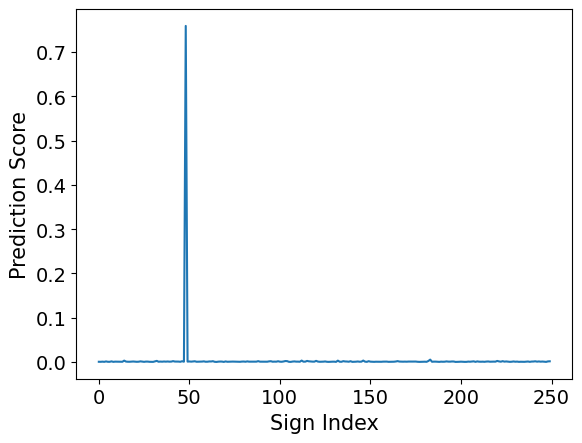

In [15]:
pd.Series(prediction['outputs']).plot(xlabel = "Sign Index", ylabel = "Prediction Score")

In [16]:
total = 0
for i in prediction['outputs']:
    total= total+i

total

1.0000000249128789

In [17]:
# create new data

In [18]:
xyz

,frame,row_id,type,landmark_index,x,y,z
0,103,103-face-0,face,0,0.437886,0.437599,-0.051134
1,103,103-face-1,face,1,0.443258,0.392901,-0.067054
2,103,103-face-2,face,2,0.443997,0.409998,-0.042990
3,103,103-face-3,face,3,0.435256,0.362771,-0.039492
4,103,103-face-4,face,4,0.443780,0.381762,-0.068013
...,...,...,...,...,...,...,...
57010,207,207-right_hand-16,right_hand,16,NaN,NaN,NaN
57011,207,207-right_hand-17,right_hand,17,NaN,NaN,NaN
57012,207,207-right_hand-18,right_hand,18,NaN,NaN,NaN
57013,207,207-right_hand-19,right_hand,19,NaN,NaN,NaN


## Format Newly Created Test Data

In [19]:
def create_landmarks_df(results, frame, xyz):
    xyz_skel = xyz[['type', 'landmark_index']].drop_duplicates().reset_index(drop=True).copy()
    face = pd.DataFrame()
    if results.face_landmarks is not None:
        for i, point in enumerate(results.face_landmarks.landmark):
            face.loc[i,'x'] = point.x
            face.loc[i,'y'] = point.y
            face.loc[i,'z'] = point.z

    pose = pd.DataFrame()
    if results.pose_landmarks is not None:
        for i, point in enumerate(results.pose_landmarks.landmark):
            pose.loc[i,'x'] = point.x
            pose.loc[i,'y'] = point.y
            pose.loc[i,'z'] = point.z

    left_hand = pd.DataFrame()
    if results.left_hand_landmarks is not None:
        for i, point in enumerate(results.left_hand_landmarks.landmark):
            left_hand.loc[i,'x'] = point.x
            left_hand.loc[i,'y'] = point.y
            left_hand.loc[i,'z'] = point.z

    right_hand = pd.DataFrame()
    if results.right_hand_landmarks is not None:
        for i, point in enumerate(results.right_hand_landmarks.landmark):
            right_hand.loc[i,'x'] = point.x
            right_hand.loc[i,'y'] = point.y
            right_hand.loc[i,'z'] = point.z

    face = face.reset_index().rename(columns={'index':'landmark_index'}).assign(type='face') 
    pose = pose.reset_index().rename(columns={'index':'landmark_index'}).assign(type='pose') 
    left_hand = left_hand.reset_index().rename(columns={'index':'landmark_index'}).assign(type='left_hand') 
    right_hand = right_hand.reset_index().rename(columns={'index':'landmark_index'}).assign(type='right_hand') 

    landmarks = pd.concat([face, pose, left_hand, right_hand]).reset_index(drop=True)
    
    landmarks = xyz_skel.merge(landmarks, on = ['type', 'landmark_index'], how='left')
    landmarks = landmarks.assign(frame=frame)
    return landmarks

## Test with Raw MediaPipe Holistic
### Test Criterias

In [20]:
import copy
import mediapipe as mp
import sys
import cv2

def get_values(file_name, xyz):
    mp_drawing = mp.solutions.drawing_utils
    mp_holistic = mp.solutions.holistic

    holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, model_complexity=2)
    sys.argv[1] = file_name
    cap = cv2.VideoCapture(sys.argv[1])

    if cap.isOpened() == False:
        print("Error opening video stream or file")
        raise TypeError

    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    res_mult = 2
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    print(frame_rate)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(length)


    max_right = 0
    max_left = 0
    count_right = 0
    count_left = 0
    right = 0
    left = 0
    right_hand_miss = []
    left_hand_miss = []
    i =0
    j =0
    video = []
    all_image = []
    results = None
    batch = 2 * frame_rate
    fix = False
    next_fix = False
    frame = 0
    all_landmarks = []



    while cap.isOpened():
        frame = frame+1
        ret, image = cap.read()
        if not ret:
            break
        image = cv2.resize(image, (frame_width*res_mult, frame_height*res_mult))

        #results.face_landmarks diye coordinates access kora jabe (face_landmarks, right_hand_landmarks, left_hand_landmarks, pose_landmarks)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = holistic.process(image)
        all_image.append([i, image, results])
        #results.right_hand_landmarks = copy.deepcopy(None)
        landmarks = create_landmarks_df(results, frame, xyz)
        all_landmarks.append(landmarks)
        i=i+1
        j=j+1
        
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.face_landmarks,
                                  mp_holistic.FACEMESH_CONTOURS,
                                  mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=0), mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=0))

        #mp_drawing.draw_landmarks?? to see the function params
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks,
                                  mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(80,22,10), thickness=4, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(80,44,121), thickness=4, circle_radius=1))

        mp_drawing.draw_landmarks(image, results.left_hand_landmarks,
                                  mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(121,22,76), thickness=4, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(121,44,250), thickness=4, circle_radius=1))

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=4, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=4, circle_radius=1))

    return all_landmarks

In [21]:
file = "/home/reyazul/Desktop/Thesis/Research Codebase/food.mp4"
landmarks = get_values(file, xyz)
landmarks = pd.concat(landmarks).reset_index(drop=True).to_parquet('jump1.parquet')

I0000 00:00:1705649807.357083   38448 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705649807.360030   38506 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 22.3.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


29.97002997002997
63


In [22]:
pq_file = 'jump1.parquet'
xyz_np = load_relevant_data_subset(pq_file)

In [23]:
before_opt = 0
for i in range(500):
    prediction = prediction_fn(inputs=xyz_np)
    pred = prediction['outputs'].argmax()
    sign = ORD2SIGN[pred]
    pred_conf = prediction['outputs'][pred]
    before_opt=before_opt+pred_conf
    #print(f'Sign {sign} {pred} with confidence {pred_conf:0.4}')
print(sign)
avg=before_opt/500
print(avg)

food
0.6914337941408157


<AxesSubplot: title={'center': 'MediaPipe Holistic'}, xlabel='Sign Index', ylabel='Prediction Score'>

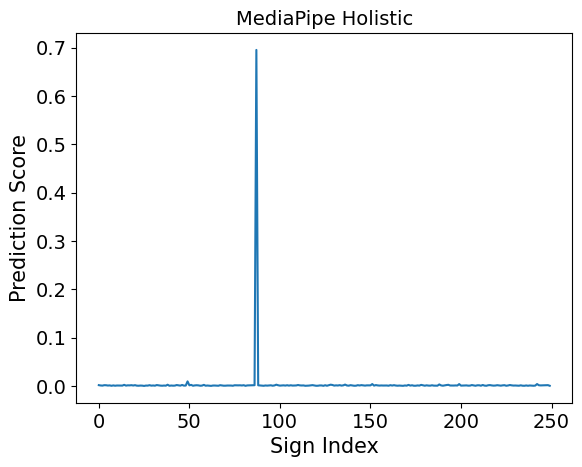

In [24]:
pd.Series(prediction['outputs']).plot(xlabel = "Sign Index", ylabel = "Prediction Score", title="MediaPipe Holistic")

### Animating the Frames

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [26]:
path_to_sign = 'jump1.parquet'
sign = pd.read_parquet(f'{path_to_sign}')
sign.y = sign.y * -1

In [27]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

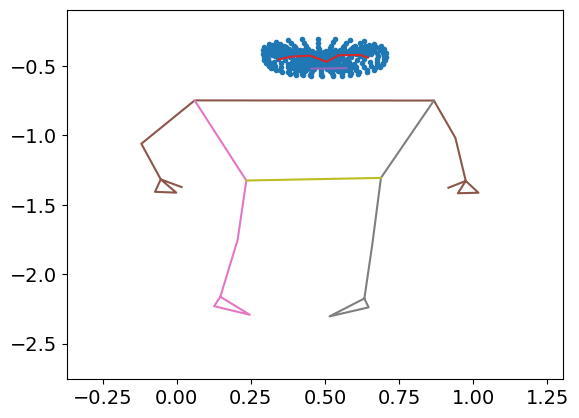

In [28]:
def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)


## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())


## Test with MediaPipe + Algorithm

In [29]:
from translation import translate
from prev_and_next import generate_new_list

def get_values_optimized(file_name, xyz):
    mp_drawing = mp.solutions.drawing_utils
    mp_holistic = mp.solutions.holistic

    holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, model_complexity=2)
    sys.argv[1] = file_name
    cap = cv2.VideoCapture(sys.argv[1])
    
    if cap.isOpened() == False:
        print("Error opening video stream or file")
        raise TypeError

    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    res_mult = 2
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    print(frame_rate)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(length)


    max_right = 0
    max_left = 0
    count_right = 0
    count_left = 0
    right = 0
    left = 0
    right_hand_miss = []
    left_hand_miss = []
    i =0
    j =0
    video = []
    all_image = []
    results = None
    batch = 5
    fix = False
    next_fix = False
    frame = 0
    all_landmarks = []
    first_detect = False

    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            break
        image = cv2.resize(image, (frame_width*res_mult, frame_height*res_mult))

        #results.face_landmarks diye coordinates access kora jabe (face_landmarks, right_hand_landmarks, left_hand_landmarks, pose_landmarks)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = holistic.process(image)
        all_image.append([i, image, results])
        i=i+1
        j=j+1
        
        if(first_detect==False and results.left_hand_landmarks != None):
            first_detect = True



        if(i >0 and i%batch==0 and results.left_hand_landmarks != None and fix==False):
            fix = True
        elif(i >0 and i%batch==0 and results.left_hand_landmarks == None and fix==False):
            next_fix = True
        elif(next_fix==True) and results.left_hand_landmarks != None:
            fix = True
            next_fix = False
        elif(j==length):
            fix = True
            next_fix = False


        if (results.left_hand_landmarks == None):
            count_left = count_left+1
            if(count_left>max_left):
                max_left = count_left
            if(first_detect==True):
                left_hand_miss.append(i)
                continue

        else:
            count_left = 0
            pose_x = results.pose_landmarks.landmark[15].x
            pose_y = results.pose_landmarks.landmark[15].y
            pose_z = results.pose_landmarks.landmark[15].z
            pose_list = [pose_x, pose_y, pose_z]

            left_hand_x = results.left_hand_landmarks.landmark[0].x
            left_hand_y = results.left_hand_landmarks.landmark[0].y
            left_hand_z = results.left_hand_landmarks.landmark[0].z
            left_hand_list = [left_hand_x, left_hand_y, left_hand_z]

            translate_x = left_hand_x - pose_x
            translate_y = left_hand_y - pose_y
            translate_z = left_hand_z - pose_z
            translate_list = [translate_x, translate_y, translate_z]
            new_pose_list = translate([pose_list], translate_list)

            setattr(results.pose_landmarks.landmark[15], 'x', new_pose_list[0])
            setattr(results.pose_landmarks.landmark[15], 'y', new_pose_list[1])
            setattr(results.pose_landmarks.landmark[15], 'z', new_pose_list[2])
            
            
            setattr(results.pose_landmarks.landmark[17], 'x', results.left_hand_landmarks.landmark[17].x)
            setattr(results.pose_landmarks.landmark[17], 'y', results.left_hand_landmarks.landmark[17].y)
            setattr(results.pose_landmarks.landmark[17], 'z', results.left_hand_landmarks.landmark[17].z)

            setattr(results.pose_landmarks.landmark[19], 'x', results.left_hand_landmarks.landmark[5].x)
            setattr(results.pose_landmarks.landmark[19], 'y', results.left_hand_landmarks.landmark[5].y)
            setattr(results.pose_landmarks.landmark[19], 'z', results.left_hand_landmarks.landmark[5].z)

            setattr(results.pose_landmarks.landmark[21], 'x', results.left_hand_landmarks.landmark[9].x)
            setattr(results.pose_landmarks.landmark[21], 'y', results.left_hand_landmarks.landmark[9].y)
            setattr(results.pose_landmarks.landmark[21], 'z', results.left_hand_landmarks.landmark[9].z)

        #for face (FACEMESH_TESSELATION, )FACEMESH_CONTOURS)
        #mp_holistic.FACE_CONNECTIONS (which joints connect which)
        # we will only focus on left hand for this case, as these signs are mostly single-handed

        if(fix==True):
            fix_left_hand_miss = generate_new_list(left_hand_miss)

            for j in range(len(fix_left_hand_miss)):
                start = fix_left_hand_miss[j][0]
                end = fix_left_hand_miss[j][1]
                multiplier = 1;
                for k in range(start+1, end):
                    all_image[k-1][2].left_hand_landmarks = copy.deepcopy(results.left_hand_landmarks)
                    for landmarks in range(len(results.left_hand_landmarks.landmark)):
                        #print(landmarks)
                        if(all_image[start-1][2].left_hand_landmarks==None):
                            l=2
                        else:
                            l=1
                        # print("start")
                        # print(all_image[start-l][2].left_hand_landmarks.landmark[landmarks].x)
                        # print("end")
                        # print(all_image[end-1][2].left_hand_landmarks.landmark[landmarks].x)
                        # print("average")
                        #print((all_image[start-l][2].left_hand_landmarks.landmark[landmarks].x+(all_image[end-1][2].left_hand_landmarks.landmark[landmarks].x-all_image[start-l][2].left_hand_landmarks.landmark[landmarks].x)*(multiplier/(end-start))))

                        setattr(all_image[k-1][2].left_hand_landmarks.landmark[landmarks], 'x', (all_image[start][2].left_hand_landmarks.landmark[landmarks].x+(all_image[end-l][2].left_hand_landmarks.landmark[landmarks].x-all_image[start][2].left_hand_landmarks.landmark[landmarks].x)*(multiplier/(end-start))))
                        setattr(all_image[k-1][2].left_hand_landmarks.landmark[landmarks], 'y', (all_image[start][2].left_hand_landmarks.landmark[landmarks].y+(all_image[end-l][2].left_hand_landmarks.landmark[landmarks].y-all_image[start][2].left_hand_landmarks.landmark[landmarks].y)*(multiplier/(end-start))))
                        setattr(all_image[k-1][2].left_hand_landmarks.landmark[landmarks], 'z', (all_image[start][2].left_hand_landmarks.landmark[landmarks].z+(all_image[end-l][2].left_hand_landmarks.landmark[landmarks].z-all_image[start][2].left_hand_landmarks.landmark[landmarks].z)*(multiplier/(end-start))))
                    multiplier = multiplier+1


                    left_hand_miss = []
                    pose_x = all_image[k-1][2].pose_landmarks.landmark[15].x
                    pose_y = all_image[k-1][2].pose_landmarks.landmark[15].y
                    pose_z = all_image[k-1][2].pose_landmarks.landmark[15].z
                    pose_list = [pose_x, pose_y, pose_z]

                    left_hand_x = all_image[k-1][2].left_hand_landmarks.landmark[0].x
                    left_hand_y = all_image[k-1][2].left_hand_landmarks.landmark[0].y
                    left_hand_z = all_image[k-1][2].left_hand_landmarks.landmark[0].z
                    left_hand_list = [left_hand_x, left_hand_y, left_hand_z]

                    translate_x = left_hand_x - pose_x
                    translate_y = left_hand_y - pose_y
                    translate_z = left_hand_z - pose_z
                    translate_list = [translate_x, translate_y, translate_z]
                    new_pose_list = translate([pose_list], translate_list)

                    setattr(all_image[k-1][2].pose_landmarks.landmark[15], 'x', new_pose_list[0])
                    setattr(all_image[k-1][2].pose_landmarks.landmark[15], 'y', new_pose_list[1])
                    setattr(all_image[k-1][2].pose_landmarks.landmark[15], 'z', new_pose_list[2])
                    
                    setattr(all_image[k-1][2].pose_landmarks.landmark[17], 'x', all_image[k-1][2].left_hand_landmarks.landmark[17].x)
                    setattr(all_image[k-1][2].pose_landmarks.landmark[17], 'y', all_image[k-1][2].left_hand_landmarks.landmark[17].y)
                    setattr(all_image[k-1][2].pose_landmarks.landmark[17], 'z', all_image[k-1][2].left_hand_landmarks.landmark[17].z)

                    setattr(all_image[k-1][2].pose_landmarks.landmark[19], 'x', all_image[k-1][2].left_hand_landmarks.landmark[5].x)
                    setattr(all_image[k-1][2].pose_landmarks.landmark[19], 'y', all_image[k-1][2].left_hand_landmarks.landmark[5].y)
                    setattr(all_image[k-1][2].pose_landmarks.landmark[19], 'z', all_image[k-1][2].left_hand_landmarks.landmark[5].z)

                    setattr(all_image[k-1][2].pose_landmarks.landmark[21], 'x', all_image[k-1][2].left_hand_landmarks.landmark[9].x)
                    setattr(all_image[k-1][2].pose_landmarks.landmark[21], 'y', all_image[k-1][2].left_hand_landmarks.landmark[9].y)
                    setattr(all_image[k-1][2].pose_landmarks.landmark[21], 'z', all_image[k-1][2].left_hand_landmarks.landmark[9].z)

                    all_image[k-1][1].flags.writeable = True
                    all_image[k-1][1] = cv2.cvtColor(all_image[k-1][1], cv2.COLOR_RGB2BGR)

                    mp_drawing.draw_landmarks(all_image[k-1][1], all_image[k-1][2].face_landmarks,
                                              mp_holistic.FACEMESH_CONTOURS,
                                              mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=0),
                                              mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=0))

                    # mp_drawing.draw_landmarks?? to see the function params
                    mp_drawing.draw_landmarks(all_image[k-1][1], all_image[k-1][2].right_hand_landmarks,
                                              mp_holistic.HAND_CONNECTIONS,
                                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=4, circle_radius=1),
                                              mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=4, circle_radius=1))

                    mp_drawing.draw_landmarks(all_image[k-1][1], all_image[k-1][2].left_hand_landmarks,
                                              mp_holistic.HAND_CONNECTIONS,
                                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=4, circle_radius=1),
                                              mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=4, circle_radius=1))

                    mp_drawing.draw_landmarks(all_image[k-1][1], all_image[k-1][2].pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=4, circle_radius=1),
                                              mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=4, circle_radius=1))

                    video.append([k-1, all_image[k-1][1]])

            fix = False


        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.face_landmarks,
                                  mp_holistic.FACEMESH_CONTOURS,
                                  mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=0), mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=0))

        #mp_drawing.draw_landmarks?? to see the function params
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks,
                                  mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(80,22,10), thickness=4, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(80,44,121), thickness=4, circle_radius=1))

        mp_drawing.draw_landmarks(image, results.left_hand_landmarks,
                                  mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(121,22,76), thickness=4, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(121,44,250), thickness=4, circle_radius=1))

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=4, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=4, circle_radius=1))

        video.append([i, image])
    
    for frame_data in sorted(all_image, key=lambda x: x[0]):
        landmarks = create_landmarks_df(frame_data[2], frame, xyz)
        all_landmarks.append(landmarks)
        
    holistic.close()
    cap.release()  # Release the video capture object
    cv2.destroyAllWindows()  # Close all OpenCV windows
        

    return all_landmarks

In [30]:
file = "/home/reyazul/Desktop/Thesis/Research Codebase/food.mp4"
landmarks = get_values_optimized(file, xyz)
landmarks = pd.concat(landmarks).reset_index(drop=True).to_parquet('jump2.parquet')

I0000 00:00:1705649845.666102   38448 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705649845.667189   38664 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 22.3.6), renderer: Mesa Intel(R) UHD Graphics (CML GT2)


29.97002997002997
63


In [31]:
pq_file = 'jump2.parquet'
xyz_np = load_relevant_data_subset(pq_file)

In [32]:
after_opt = 0
for i in range(500):
    prediction = prediction_fn(inputs=xyz_np)
    pred = prediction['outputs'].argmax()
    sign = ORD2SIGN[pred]
    pred_conf = prediction['outputs'][pred]
    after_opt=after_opt+pred_conf
    #print(f'Sign {sign} {pred} with confidence {pred_conf:0.4}')
print(sign)   
avg = after_opt/500
print(avg)

food
0.3757867832779884


<AxesSubplot: title={'center': 'MediaPipe Holistic + Algorithm'}, xlabel='Sign Index', ylabel='Prediction Score'>

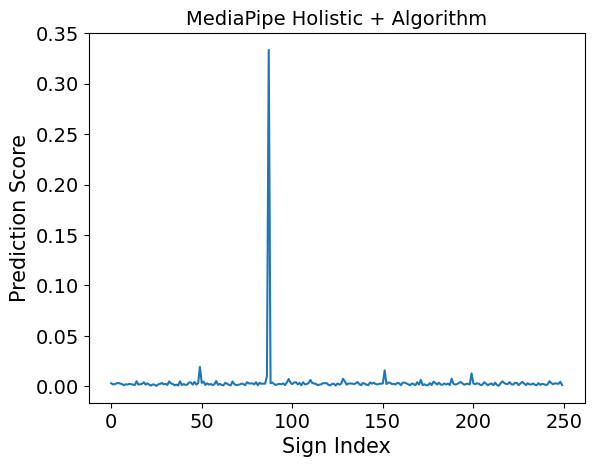

In [33]:
pd.Series(prediction['outputs']).plot(xlabel = "Sign Index", ylabel = "Prediction Score", title="MediaPipe Holistic + Algorithm")